In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# 1. Read in data set, explore

In [2]:
# Load the processed data

df_telecom = pd.read_csv('../churn_clean2.csv') #telecom_data1.csv')

In [3]:
df_telecom.head(3)

,Unnamed: 0,ID,Customer_id,Interaction,UID,zip,Lat,Lng,City,State,Population,County,Area,Timezone,Job,Children,Age,Income,Marital,Churn,Gender,outage_sec_perweek,email,contacts,yearly_equip_failure,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharge,Bandwidth_GB_Year,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,K409198,d821c3c2-b41c-473d-bf58-92377f1519b3,2891dede742c09f068a1c971378070d4,68866,40.97538,-99.12858,Pleasanton,NE,963,Buffalo,Rural,America/Chicago,Operational researcher,4,55,32932.87,Divorced,Yes,Male,7.978323,10,0,1,No,One year,Yes,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Credit Card (automatic),6.795513,172.455519,1070.297083,3,3,4,2,4,5,3,3
1,2,2,S120509,9c33fb5e-1ce7-4270-a01d-8d14a59446c1,6768919090b0c6356852922898b157dd,27896,35.79138,-77.97650,Wilson,NC,20681,Wilson,Suburban,America/New_York,Technical brewer,5,63,28981.00,Widowed,No,Female,11.699080,12,0,1,Yes,Month-to-month,No,Yes,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Bank Transfer(automatic),1.156681,242.632554,806.090526,5,5,4,3,4,4,3,5
2,3,3,K191035,8624e3ab-f12a-40df-aef2-897ad7742f2c,c8183a1f8116e27b11ece98943eaf87c,63361,38.96252,-91.55446,Montgomery City,MO,4193,Montgomery,Rural,America/Chicago,Editorial assistant,0,77,46067.67,Never Married,No,Female,10.752800,9,0,1,Yes,Two Year,Yes,No,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes,Credit Card (automatic),15.754144,159.947583,1843.045070,5,5,4,4,2,3,5,4


In [6]:
# Define features and target variables

X = df_telecom.drop('Churn',axis=1)   #Feature Matrix
Y = df_telecom['Churn']          #Target Variable

# Print dimensions
print(X.shape)
print(Y.shape)

(10000, 50)
(10000,)


# 2. Feature Engineering

## Variable transformation 

In [7]:
# Transform Y to 0/1

Y = pd.Series(np.where(Y.values=='Yes',1,0))

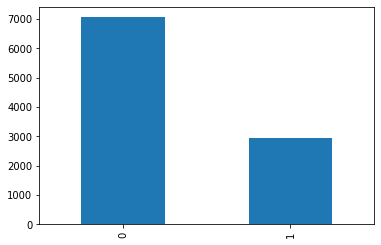

In [8]:
# Percent counts of Y
Y.value_counts().plot(kind='bar')

In [10]:
X.dtypes

Unnamed: 0                int64
ID                        int64
Customer_id              object
Interaction              object
UID                      object
zip                      object
Lat                     float64
Lng                     float64
City                     object
State                    object
Population                int64
County                   object
Area                     object
Timezone                 object
Job                      object
Children                  int64
Age                       int64
Income                  float64
Marital                  object
Gender                   object
outage_sec_perweek      float64
email                     int64
contacts                  int64
yearly_equip_failure      int64
Techie                   object
Contract                 object
Port_modem               object
Tablet                   object
InternetService          object
Phone                    object
Multiple                 object
OnlineSe

In [9]:
# transform zip to categorical

X['zip']= X['zip'].astype('str')

## Variable selection

### Continuous variables

In [11]:
cols_cont = X.select_dtypes([np.number]).drop(['Unnamed: 0', 'ID'], axis=1).columns.values.tolist() #only numeric
cols_cont = cols_cont[:-8] #remove items 
cols_cont

['Lat',
 'Lng',
 'Population',
 'Children',
 'Age',
 'Income',
 'outage_sec_perweek',
 'email',
 'contacts',
 'yearly_equip_failure',
 'Tenure',
 'MonthlyCharge',
 'Bandwidth_GB_Year']

In [12]:
# Cont cols (normalize for KNN)

# Continuous cols (normalize-for KNN)
X_cont = X[cols_cont]
X_cont.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,40.97538,-99.12858,963,4,55,32932.87,7.978323,10,0,1,6.795513,172.455519,1070.297083
1,35.79138,-77.97650,20681,5,63,28981.00,11.699080,12,0,1,1.156681,242.632554,806.090526
2,38.96252,-91.55446,4193,0,77,46067.67,10.752800,9,0,1,15.754144,159.947583,1843.045070


### Categorical variables

In [15]:
# Cat cols-full list

cols_cat_all = X.loc[:, X.dtypes == np.object].columns.values.tolist() #have to translate back to list format
cols_cat_all = cols_cat_all[3:] #remove the first three cols, related to cust ID
cols_cat_all

['zip',
 'City',
 'State',
 'County',
 'Area',
 'Timezone',
 'Job',
 'Marital',
 'Gender',
 'Techie',
 'Contract',
 'Port_modem',
 'Tablet',
 'InternetService',
 'Phone',
 'Multiple',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'PaymentMethod']

In [23]:
# Cat cols-only those with limited tot unique value (otherwise too many categories created for dummies)

t = X[cols_cat_all].nunique().sort_values(ascending=False)
t = t.loc[lambda t: t < 50]  # change value to what is desired here, from 50
cols_cat_all_red = t.index.values.tolist()
X[cols_cat_all_red].nunique().to_frame('tot unique') #updated reduced list 


,tot unique
Timezone,24
Marital,5
PaymentMethod,4
InternetService,3
Contract,3
Gender,3
Area,3
Multiple,2
Phone,2
Tablet,2


In [24]:
# 1. Create dummies-for categorical cols (use reduced col list)

X_cat = pd.get_dummies(X[cols_cat_all_red], drop_first=True) # drop first as it is redundant
print('number of cat cols chosen: ', X[cols_cat_all_red].shape[1])
print('total cat cols after one hot encoding: ', X_cat.shape[1])
X_cat.head(3)

number of cat cols chosen:  19
total cat cols after one hot encoding:  50


,Timezone_America/Boise,Timezone_America/Chicago,Timezone_America/Denver,Timezone_America/Detroit,Timezone_America/Indiana/Indianapolis,Timezone_America/Indiana/Knox,Timezone_America/Indiana/Marengo,Timezone_America/Indiana/Petersburg,Timezone_America/Indiana/Tell_City,Timezone_America/Indiana/Vincennes,Timezone_America/Juneau,Timezone_America/Kentucky/Louisville,Timezone_America/Los_Angeles,Timezone_America/Menominee,Timezone_America/New_York,Timezone_America/Nome,Timezone_America/North_Dakota/Beulah,Timezone_America/North_Dakota/Center,Timezone_America/North_Dakota/New_Salem,Timezone_America/Phoenix,Timezone_America/Puerto_Rico,Timezone_America/Sitka,Timezone_Pacific/Honolulu,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Contract_One year,Contract_Two Year,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Multiple_Yes,Phone_Yes,Tablet_Yes,PaperlessBilling_Yes,Techie_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Port_modem_Yes
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,1


In [25]:
# 2. For Naive Bayes, choose all cat columns and label encode 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_cat_nb = X[cols_cat_all].apply(le.fit_transform)
print('number of cat cols in NB: ', X[cols_cat_all].shape[1])
print('total cat cols in NB after one hot encoding: ', X_cat_nb.shape[1])
X_cat_nb.head(3) 

number of cat cols in NB:  24
total cat cols in NB after one hot encoding:  24


,zip,City,State,County,Area,Timezone,Job,Marital,Gender,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod
0,6086,4314,29,186,0,2,412,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1
1,1690,5967,27,1561,1,15,592,4,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0
2,5481,3568,24,967,0,2,183,2,0,1,2,1,0,0,1,1,0,0,0,0,0,1,1,1


In [26]:
# Join Cat and Noncat together

X_all = pd.concat([X_cont, X_cat],axis=1)
X_all_nb = pd.concat([X_cont, X_cat_nb],axis=1)

print('total cols for final df: ', X_all.shape[1]) 
print('total cols for final df, Naive Bayes: ',X_all_nb.shape[1])
X_all_nb.head()

total cols for final df:  63
total cols for final df, Naive Bayes:  37


,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,zip,City,State,County,Area,Timezone,Job,Marital,Gender,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod
0,40.97538,-99.12858,963,4,55,32932.87,7.978323,10,0,1,6.795513,172.455519,1070.297083,6086,4314,29,186,0,2,412,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1
1,35.79138,-77.97650,20681,5,63,28981.00,11.699080,12,0,1,1.156681,242.632554,806.090526,1690,5967,27,1561,1,15,592,4,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0
2,38.96252,-91.55446,4193,0,77,46067.67,10.752800,9,0,1,15.754144,159.947583,1843.045070,5481,3568,24,967,0,2,183,2,0,1,2,1,0,0,1,1,0,0,0,0,0,1,1,1
3,33.28614,-96.19999,2801,2,82,18421.48,14.913540,15,2,0,17.087227,119.956840,2083.890427,6663,891,44,684,0,2,504,4,1,1,2,0,0,0,1,0,1,0,0,0,1,0,1,3
4,30.38842,-92.10134,7968,1,85,36673.08,8.147417,16,2,1,1.670972,149.948316,295.720835,6184,5326,18,1354,0,2,266,3,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,3


# Train/Test Split Data

In [27]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, Y,
    test_size=0.3,
    random_state=1
)

# for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_all_nb, Y,
    test_size=0.3,
    random_state=1
)

In [28]:
# Print dimensions

print('Train cols: ', X_train.shape[1])
print('Test cols: ', X_test.shape[1])
print('Train cols, NB: ', X_train_nb.shape[1])
print('Test cols, NB: ', X_test_nb.shape[1])

Train cols:  63
Test cols:  63
Train cols, NB:  37
Test cols, NB:  37


# Predictive Modeling Techniques

# 1. KNN

This section covers KNN

In [29]:
# Load the K-Nearest Neighbors class
from sklearn.neighbors import KNeighborsClassifier

# Load the metrics libraries (used for all methods)
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

In [30]:
# Scale the data for cols_cont 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() #MinMaxScaler()

X_train_std = X_train.copy() #copy train features df for KNN
X_test_std = X_test.copy()  #copy test features df for KNN
#transform cont cols only
X_train_std[cols_cont] = scaler.fit_transform(X_train_std[cols_cont]) 
X_test_std[cols_cont] = scaler.transform(X_test_std[cols_cont])

X_train_std.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year,Timezone_America/Boise,Timezone_America/Chicago,Timezone_America/Denver,Timezone_America/Detroit,Timezone_America/Indiana/Indianapolis,Timezone_America/Indiana/Knox,Timezone_America/Indiana/Marengo,Timezone_America/Indiana/Petersburg,Timezone_America/Indiana/Tell_City,Timezone_America/Indiana/Vincennes,Timezone_America/Juneau,Timezone_America/Kentucky/Louisville,Timezone_America/Los_Angeles,Timezone_America/Menominee,Timezone_America/New_York,Timezone_America/Nome,Timezone_America/North_Dakota/Beulah,Timezone_America/North_Dakota/Center,Timezone_America/North_Dakota/New_Salem,Timezone_America/Phoenix,Timezone_America/Puerto_Rico,Timezone_America/Sitka,Timezone_Pacific/Honolulu,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Contract_One year,Contract_Two Year,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Multiple_Yes,Phone_Yes,Tablet_Yes,PaperlessBilling_Yes,Techie_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Port_modem_Yes
2228,0.493212,0.236043,0.309613,0.400737,0.073726,-0.200289,-0.512070,0.333118,0.007498,-0.631386,-0.947131,-0.754619,-0.991069,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,1,0,1,0,0
5910,-0.923864,-0.192904,-0.627842,-0.503569,0.889091,0.493222,0.813882,1.324682,0.007498,-0.631386,1.336839,-0.986630,1.388808,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,1,1,1,1,1,0,0,0,0
1950,0.460007,1.083534,-0.280402,-0.955722,-0.789603,2.125491,1.207838,1.985725,0.007498,-0.631386,-1.240883,1.339104,-1.162057,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,1,0,1,0,1,0,0,1,1,1


In [31]:
# Train a K-Nearest Neighbors model

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_std, y_train) #Note: only X_train is std (not y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [32]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = knn.predict(X_test_std)
y_prob = knn.predict_proba(X_test_std)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)


total accuracy = 82.1%
total precision = 77.0%
total recall = 56.2%
auc = 0.87%


# 2. Naive Bayes

This section covers Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
nb = model.fit(X_train_nb,y_train_nb)

In [34]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = nb.predict(X_test_nb)
y_prob = nb.predict_proba(X_test_nb)[:, 1]

acc = accuracy_score(y_test_nb, y_pred)*100
precision = precision_score(y_test_nb, y_pred)*100
recall = recall_score(y_test_nb, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test_nb, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 81.9%
total precision = 64.6%
total recall = 85.8%
auc = 0.91%


# 3. Decision Tree

This section covers Decision Trees

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
# Train a Random Forest

tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = tree.predict(X_test)
y_prob = tree.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 86.4%
total precision = 80.4%
total recall = 71.5%
auc = 0.93%


# 4. Random Forest 

This section covers Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
# Train a Random Forest

forest = RandomForestClassifier(
    n_estimators=100,
    max_features=15,
    max_depth=5,
    random_state=1,
)
forest.fit(X_train, y_train) 


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [40]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = forest.predict(X_test)
y_prob = forest.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))
#confusion_matrix(y_test, y_pred)

total accuracy = 86.9%
total precision = 78.5%
total recall = 76.7%
auc = 0.94%


## Feature Importance for Random Forest

In [41]:
feature_imp = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp[:10]

Tenure                         0.346392
Bandwidth_GB_Year              0.266096
MonthlyCharge                  0.128585
StreamingMovies_Yes            0.085970
Contract_Two Year              0.051943
StreamingTV_Yes                0.046871
Contract_One year              0.032045
Multiple_Yes                   0.011924
InternetService_Fiber Optic    0.004989
Lat                            0.002555
dtype: float64

No handles with labels found to put in legend.


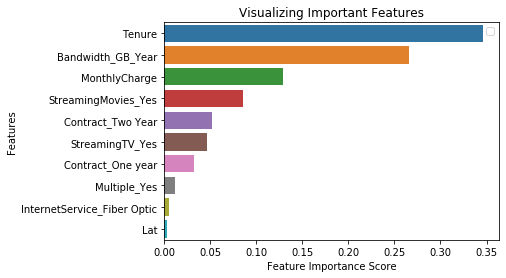

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# 4. Gradient Boosting (not covered)
This section covers Gradient Boosting

In [43]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

## AdaBoost

In [44]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)

In [45]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = ada.predict(X_test)
y_prob = ada.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 89.7%
total precision = 84.3%
total recall = 80.1%
auc = 0.96%


## Gradient boost

In [46]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 90.0%
total precision = 85.7%
total recall = 79.6%
auc = 0.96%


In [48]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate=.02, max_features=15, max_depth=5, random_state=1)
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.02, loss='deviance', max_depth=5,
                           max_features=15, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [49]:
# Print overall test-set accuracy, precision, recall, auc
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)*100
precision = precision_score(y_test, y_pred)*100
recall = recall_score(y_test, y_pred)*100
print('total accuracy = {:.1f}%'.format(acc))
print('total precision = {:.1f}%'.format(precision))
print('total recall = {:.1f}%'.format(recall))

auc = roc_auc_score(y_test, y_prob)
print('auc = {:.2f}%'.format(auc))

total accuracy = 88.5%
total precision = 85.1%
total recall = 74.0%
auc = 0.95%
